<a href="https://colab.research.google.com/github/Eric-Oliveira-ds/leishticIA/blob/dev/AlexNet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use pre-trained AlexNet to train and classifier leishmanioses and pyoderma images

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchviz

In [3]:
!pip install easy-explain

In [4]:
import torch
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import random
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageOps
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchviz import make_dot

## Utils

In [5]:
# Definir as transformações personalizadas
class RandomBrightnessContrast:
    def __init__(self, brightness=(0.9, 1.1), contrast=(0.9, 1.1)):
        self.brightness = brightness
        self.contrast = contrast

    def __call__(self, img):
        if random.random() > 0.5:
            enhancer = ImageEnhance.Brightness(img)
            img = enhancer.enhance(random.uniform(*self.brightness))
        if random.random() > 0.5:
            enhancer = ImageEnhance.Contrast(img)
            img = enhancer.enhance(random.uniform(*self.contrast))
        return img

class RandomCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):
        if random.random() > 0.5:
            img = ImageOps.equalize(img)
        return img

## Data Transformation

In [7]:
# Função para desnormalizar as imagens e converter para formato exibível
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Converte para formato HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Desnormaliza
    img = np.clip(img, 0, 1)  # Limita os valores entre 0 e 1 para exibição
    plt.imshow(img)

In [8]:
# Definir as transformações para o dataset
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        RandomBrightnessContrast(),
        RandomCLAHE(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
# Carregar os datasets de treino e teste
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/train/', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset_classifier/test/', transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Visualize transformations

In [10]:
# Obter um lote de imagens de treino
dataiter = iter(train_loader)
images, labels = next(dataiter)

Imagem 0, Label: 2
Imagem 1, Label: 2
Imagem 2, Label: 4
Imagem 3, Label: 4
Imagem 4, Label: 0
Imagem 5, Label: 2
Imagem 6, Label: 0
Imagem 7, Label: 2


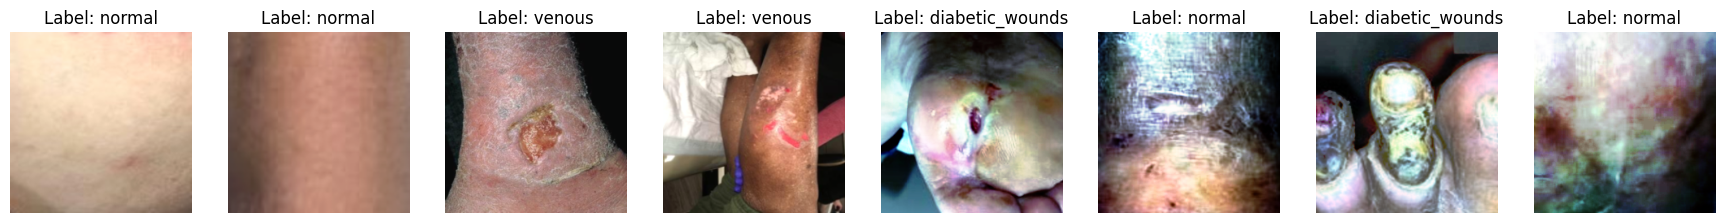

In [11]:
# Exibir as imagens com transformações
fig, axes = plt.subplots(1, len(images), figsize=(22, 10))
for i, img in enumerate(images):
    label_value = labels[i].item()
    print(f'Imagem {i}, Label: {label_value}')  # Mostra o valor do rótulo

    # Definir o rótulo baseado no valor
    if label_value == 0:
        label_text = 'diabetic_wounds'
    elif label_value == 1:
        label_text = 'leishmaniose'
    elif label_value == 2:
        label_text = 'normal'
    elif label_value == 3:
        label_text = 'pyoderma'
    elif label_value == 4:
        label_text = 'venous'
    else:
        label_text = 'unknown'

    ax = axes[i]
    ax.set_title(f"Label: {label_text}")
    ax.axis('off')
    plt.sca(ax)
    imshow(img)

plt.show()

In [12]:
train_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [13]:
test_loader.dataset.classes

['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

In [14]:
print('length of train dataset: {}'.format(len(train_loader.dataset.samples)))

length of train dataset: 1261


In [15]:
print('length of test dataset: {}'.format(len(test_loader.dataset.samples)))

length of test dataset: 40


In [16]:
# Mapeamento de classes para índices
class_to_idx = train_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


In [17]:
# Mapeamento de classes para índices
class_to_idx = test_dataset.class_to_idx
print(class_to_idx)

{'diabetic_wounds': 0, 'leishmaniose': 1, 'normal': 2, 'pyoderma': 3, 'venous': 4}


## Model Train

In [18]:
# Carregar o modelo AlexNet pré-treinado
model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

In [19]:
# Congelar os parâmetros do modelo para evitar treinar toda a rede
for param in model.parameters():
    param.requires_grad = False

In [20]:
# Modificar a última camada para se ajustar ao número de classes do seu dataset
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

In [21]:
num_classes

5

In [22]:
# Definir o otimizador e a função de perda
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [23]:
# Treinamento do modelo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
device

device(type='cpu')

In [25]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [27]:
sample_input = torch.randn(1, 3, 224, 224).to(device)  # Exemplo de entrada
y = model(sample_input)  # Passando o input pelo modelo
make_dot(y, params=dict(model.named_parameters())).render("model_architecture", format="png")

'model_architecture.png'

Epoch [1/100], Loss: 0.4435
Epoch [2/100], Loss: 0.2729
Epoch [3/100], Loss: 0.1767
Epoch [4/100], Loss: 0.2104
Epoch [5/100], Loss: 0.1692
Epoch [6/100], Loss: 0.2281
Epoch [7/100], Loss: 0.1782
Epoch [8/100], Loss: 0.1437
Epoch [9/100], Loss: 0.1609
Epoch [10/100], Loss: 0.1596
Epoch [11/100], Loss: 0.1545
Epoch [12/100], Loss: 0.1117
Epoch [13/100], Loss: 0.1165
Epoch [14/100], Loss: 0.1420
Epoch [15/100], Loss: 0.1201
Epoch [16/100], Loss: 0.1058
Epoch [17/100], Loss: 0.0941
Epoch [18/100], Loss: 0.1195
Epoch [19/100], Loss: 0.1030
Epoch [20/100], Loss: 0.0850
Epoch [21/100], Loss: 0.1067
Epoch [22/100], Loss: 0.1193
Epoch [23/100], Loss: 0.1389
Epoch [24/100], Loss: 0.1348
Epoch [25/100], Loss: 0.0877
Epoch [26/100], Loss: 0.1181
Epoch [27/100], Loss: 0.1312
Epoch [28/100], Loss: 0.0952
Epoch [29/100], Loss: 0.1112
Epoch [30/100], Loss: 0.0671
Epoch [31/100], Loss: 0.0773
Epoch [32/100], Loss: 0.1458
Epoch [33/100], Loss: 0.1064
Epoch [34/100], Loss: 0.1017
Epoch [35/100], Loss: 0

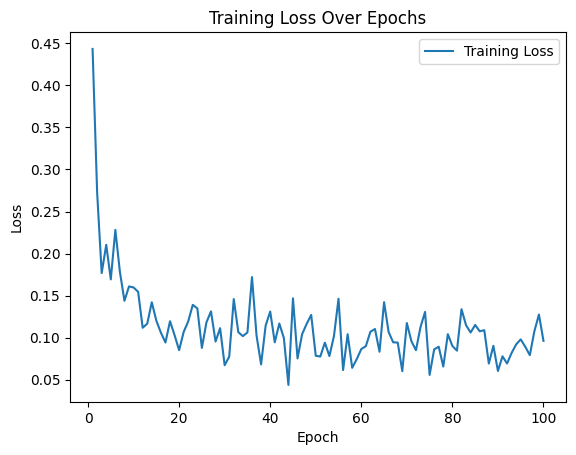

In [28]:
num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Model Evatualion

In [29]:
# Avaliação do modelo
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        # Armazene os rótulos e as previsões
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [60]:
print(f'Acurácia no conjunto de teste: {100 * correct / total:.2f}%')

Acurácia no conjunto de teste: 82.50%


In [61]:
print(classification_report(all_labels, all_predictions))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       0.86      0.75      0.80         8
           2       1.00      1.00      1.00         8
           3       0.60      0.38      0.46         8
           4       0.89      1.00      0.94         8

    accuracy                           0.82        40
   macro avg       0.81      0.82      0.81        40
weighted avg       0.81      0.82      0.81        40



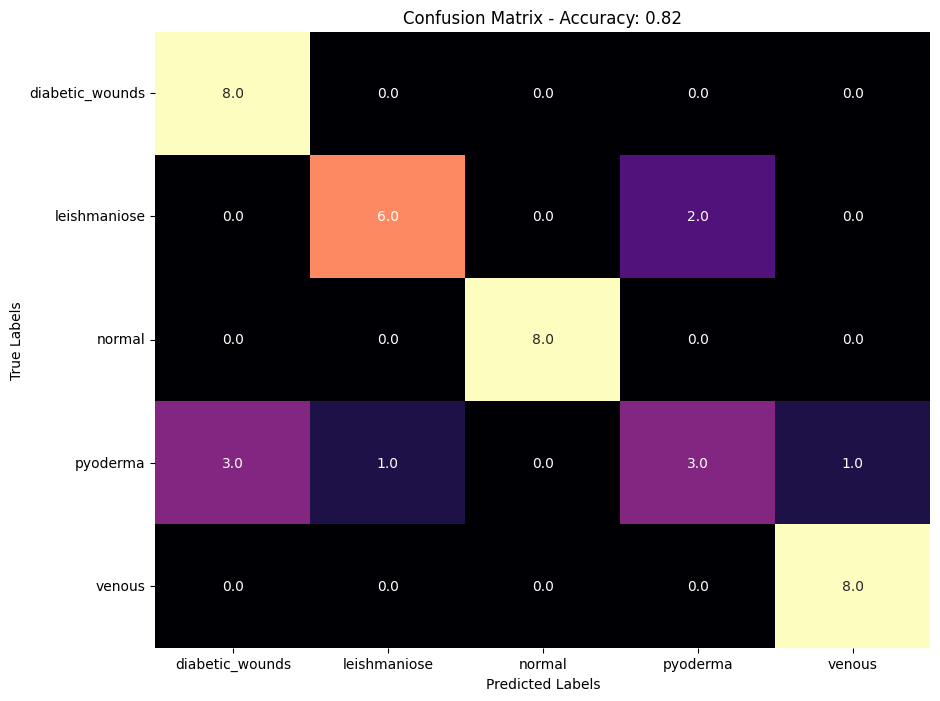

In [62]:
# Criar a matriz de confusão
cm = confusion_matrix(all_labels, all_predictions)
accuracy = accuracy_score(all_labels, all_predictions)

# Plotar a matriz de confusão com Seaborn
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt='.1f', cmap='magma', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}')
ax.set_xticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'])
ax.set_yticklabels(['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous'], rotation=0)
plt.show()

## Model Deployment

In [63]:
# Salvar o modelo após o treinamento
torch.save(model.state_dict(), f'alexnet_acc_{accuracy:.2f}_weights.pth')

# Explainable AI

## Utils

In [79]:
class AlexNetGradCAM(nn.Module):
    def __init__(self):
        super(AlexNetGradCAM, self).__init__()

        # Carrega o modelo AlexNet pré-treinado
        self.alexnet = models.alexnet(pretrained=False)
        self.alexnet.classifier[6] = nn.Linear(4096, 5)
        self.alexnet.load_state_dict(torch.load('/content/drive/MyDrive/alexnet_acc_0.82_weights.pth'))

        # Extrai as camadas convolucionais até a última camada de ativação desejada
        self.features_conv = self.alexnet.features[:12]

        # Extrai o classificador
        self.classifier = self.alexnet.classifier

        # Placeholder para os gradientes
        self.gradients = None

    # Hook para capturar os gradientes das ativações
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # Registra o hook na última camada convolucional
        h = x.register_hook(self.activations_hook)

        # Flatten e passa pelo classificador
        x = F.adaptive_avg_pool2d(x, (6, 6))  # Ajuste para o classificador da AlexNet
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    # Método para extrair os gradientes
    def get_activations_gradient(self):
        return self.gradients

    # Método para extrair as ativações
    def get_activations(self, x):
        return self.features_conv(x)

# Inicializa o modelo
model = AlexNetGradCAM()
model.eval()

# Função para aplicar o Grad-CAM
def generate_gradcam_heatmap(model, img_tensor, target_class=None):
    # Realiza a predição e captura o índice da classe
    pred = model(img_tensor)
    if target_class is None:
        target_class = pred.argmax(dim=1).item()

    # Calcula o gradiente da classe-alvo em relação à saída
    model.zero_grad()
    pred[:, target_class].backward()

    # Extrai o gradiente médio em cada canal da última camada convolucional
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Extrai as ativações da última camada convolucional
    activations = model.get_activations(img_tensor).detach()

    # Pondera as ativações pelo gradiente médio
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Calcula o heatmap médio nas ativações
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Aplica ReLU e normaliza
    heatmap = F.relu(heatmap)
    heatmap /= heatmap.max()
    return heatmap.numpy()

<ipython-input-79-7c9e9c351709>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.alexnet.load_state_dict(torch.load('/content/drive/MyDrive/alexnet_acc_0.82_weights.pth

In [80]:
# model = models.alexnet(pretrained=False)
# model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
# model.load_state_dict(torch.load(f'/content/alexnet_acc_{accuracy:.2f}_weights.pth'))
# model.eval()

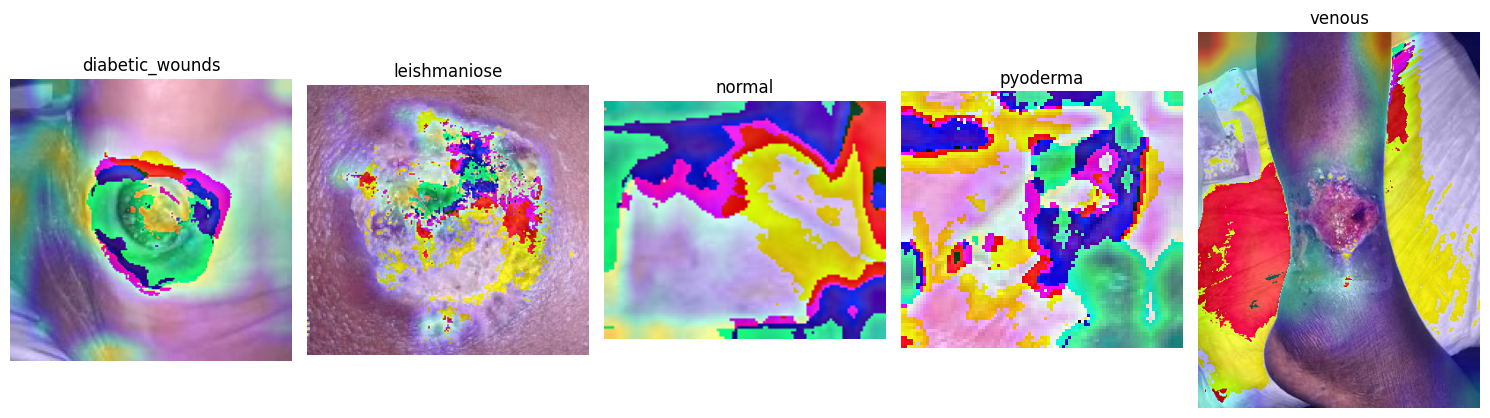

In [81]:
# Carregue uma imagem para teste
image_paths = ['/content/drive/MyDrive/dataset_classifier/test/diabetic_wounds/13_0.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/leishmaniose/Imagem do WhatsApp de 2024-10-26 à(s) 20.39.03_041c824e.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/normal/0711.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/pyoderma/Imagem do WhatsApp de 2024-10-27 à(s) 17.12.33_ea46fe56.jpg',
               '/content/drive/MyDrive/dataset_classifier/test/venous/1558.jpg']

labels = ['diabetic_wounds', 'leishmaniose', 'normal', 'pyoderma', 'venous']

# Pré-processamento das imagens
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Configura o layout dos subplots
n_rows = 1  # número de linhas
n_cols = 5  # número de colunas (ajuste conforme necessário)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

# Itera sobre as imagens e exibe com Grad-CAM
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    # Carrega e pré-processa a imagem
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)

    # Gera o heatmap Grad-CAM
    heatmap = generate_gradcam_heatmap(model, img_tensor)

    # Carrega a imagem original para sobrepor o heatmap
    img = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    jet_heatmap = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    superimposed_img = jet_heatmap * 0.4 + img
    # Converte para uint8 antes de aplicar cvtColor
    superimposed_img = np.uint8(superimposed_img)
    # Converte para RGB para exibição com matplotlib
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Exibe a imagem com título da label
    axes[i].imshow(superimposed_img)
    axes[i].set_title(label)
    axes[i].axis('off')

# Ajusta o layout
plt.tight_layout()
plt.show()

Distribuição dos Mapas de Calor:

Diabetic Wounds: O modelo parece focar na área central, onde a lesão está mais concentrada. Isso faz sentido, pois a característica da imagem de uma ferida diabética geralmente está no centro da lesão.

Leishmaniose: O mapa de calor mostra atenção dispersa ao redor da área da ferida, o que pode fazer sentido dependendo da distribuição e dos detalhes da infecção.

Normal: A imagem "normal" tem um padrão de calor mais disperso, o que sugere que o modelo não encontrou uma área específica de lesão.

Pyoderma: O modelo foca em áreas aparentemente lesadas, mas o mapa de calor parece menos denso ou difuso. Isso pode indicar que o modelo está incerto sobre a classificação ou que a característica da lesão é menos evidente.

Venous: O modelo parece focar mais nas bordas e em áreas específicas da lesão. Isso pode fazer sentido para lesões venosas, que podem ter bordas irregulares e padrões específicos.